In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[8], 'GPU')
            device = '/gpu:8'
    except RuntimeError as e:
        print(e)

print("device", device)


2024-08-27 20:07:11.106480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 20:07:11.123991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 20:07:11.138632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 20:07:11.142815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 20:07:11.155959: I tensorflow/core/platform/cpu_feature_guar

device /gpu:8


Load the data

In [2]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load HDF5 data
# h5_filename = '/home/da886/ElectronCountingProject/Small Building Blocks/Data Generated/150K_3electronsOnly.h5'#### i used this for training and saved it under weekend steps weights
# with h5py.File(h5_filename, 'r') as f:
#     images = np.array(f['images'][:100000])
#     centers = np.array(f['centers_training'][:100000])
# h5_filename = '/home/da886/Electron Counting Extended Arch/Data/100K_3electronsOnly.h5'
h5_filename ='/home/da886/Electron Counting Extended Arch/Data/Mixed100K_3electrons.h5'
with h5py.File(h5_filename, 'r') as f:
    images = np.array(f['images'])
    centers = np.array(f['centers_training'])


### raw image with box locations

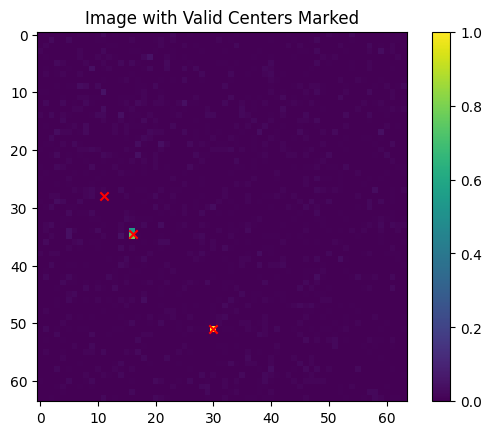

In [3]:
a = np.random.randint(0, len(images))
# a =2
image = images[a]
centerss = centers[a]

# Plot the image with valid centers
plt.imshow(image, )
valid_centers = centerss[centerss[:, 0] == 1]
for center in valid_centers:
    plt.scatter(center[1], center[2], c='red', marker='x')  # Note: center[1] is x and center[2] is y
plt.title('Image with Valid Centers Marked')
plt.colorbar()
plt.show()


Sort the boxes locations in ascending order(top left to bottom right)

In [4]:


# Function to sort centers from top-left to bottom-right
def sort_centers(centers):
    # Sort by y first, then by x
    return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

# Sort the centers for each image
sorted_centers = np.array([sort_centers(image_centers[:, 1:]) for image_centers in centers])


## Normalized Data

In [5]:

# normalized_images = (images+1e-9)/9.26
normalized_images = (images)/np.max(images)
normalized_centers = sorted_centers /  np.max(sorted_centers)
# normalized_centers = sorted_centers /  64
normalized_midpoints =normalized_centers
normalized_midpoints = tf.expand_dims(normalized_midpoints,axis =1)
normalized_midpoints_np = normalized_midpoints.numpy()

2024-08-27 20:07:26.183201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 8, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ce:00.0, compute capability: 8.0


Range for the inputs

In [6]:
np.max(normalized_images), np.min(normalized_images)

(1.0, 0.0)

Range for the outputs

In [7]:
np.max(normalized_midpoints_np), np.min(normalized_midpoints_np)

(1.0, 0.0)

In [6]:
# Perform the random split
train_images, val_images, train_midpoints, val_midpoints = train_test_split(
    normalized_images, normalized_midpoints_np, train_size=0.8, random_state=42
)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

In [9]:
train_images.shape,val_images.shape,train_midpoints.shape

((80080, 64, 64), (20020, 64, 64), (80080, 1, 3, 2))

In [8]:
batch_size = 600
train_dataset = train_dataset.shuffle(buffer_size=2000,reshuffle_each_iteration= True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)

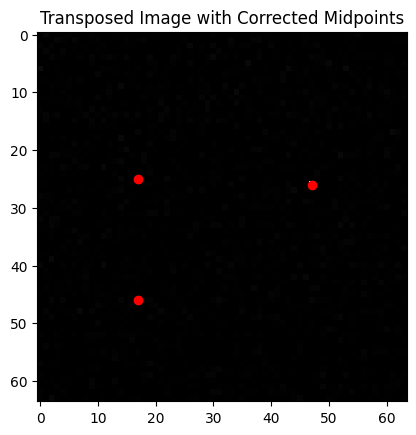

In [10]:

sample_image, sample_midpoints = next(iter(train_dataset))


# Convert TensorFlow tensors to NumPy arrays (if they are tensors)
y= np.random.randint(0,batch_size)
sample_image = np.array(sample_image[y])
sample_midpoints = np.array(sample_midpoints[y])

# # Transpose the image and correctly swap the midpoints

transposed_image = sample_image.T
transposed_midpoints_corrected = sample_midpoints[:,:, [1, 0]]  # Correctly swap x and y coordinates

# Plot the transposed image with corrected midpoints
plt.imshow(transposed_image, cmap='gray')
plt.scatter(transposed_midpoints_corrected[:,:, 0]*np.max(sorted_centers) , transposed_midpoints_corrected[:,:, 1] *np.max(sorted_centers), c='red', marker='o')
plt.title('Transposed Image with Corrected Midpoints')
plt.show()


In [11]:
normalized_midpoints 

<tf.Tensor: shape=(100100, 1, 3, 2), dtype=float32, numpy=
array([[[[0.6260103 , 0.6015972 ],
         [0.5819362 , 0.6650699 ],
         [0.23746496, 0.68169665]]],


       [[[0.46289012, 0.21614772],
         [0.16626747, 0.39904195],
         [0.46554893, 0.39904195]]],


       [[[0.6318164 , 0.17284699],
         [0.19952098, 0.7605466 ],
         [0.49880242, 0.8812176 ]]],


       ...,


       [[[0.61131865, 0.17902322],
         [0.6021391 , 0.23292968],
         [0.21614772, 0.3159082 ]]],


       [[[0.71495014, 0.46554893],
         [0.26602796, 0.69832337],
         [0.33253494, 0.89587545]]],


       [[[0.721345  , 0.74724007],
         [0.48217568, 0.7791974 ],
         [0.5812795 , 0.79354465]]]], dtype=float32)>

In [14]:
# from tensorflow.keras import layers


# input_shape = (64, 64, 1)
# num_classes = 3
# num_coordinates = 2


# x_input = layers.Input(shape=input_shape)
# #Layer 1
# x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 
# x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

# #Layer 2
# x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)

# #Layer 3
# x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)

# #Layer 4
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)

# #Layer 5
# x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.BatchNormalization()(x) 


# x = layers.Flatten()(x)


# # Bounding box output
# x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
# x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




# model = tf.keras.models.Model(x_input, x_midpoints_reshape)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 



In [14]:
from tensorflow.keras import layers


input_shape = (64, 64, 1)
num_classes = 3
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)


# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




model = tf.keras.models.Model(x_input, x_midpoints_reshape)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 



In [89]:



# Summary to check the number of parameters
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,563,846 (36.48 MB)

 Trainable params: 9,558,598 (36.46 MB)

 Non-trainable params: 5,248 (20.50 KB)

In [90]:
train_outputs = model.predict(train_images)
val_outputs = model.predict(val_images)

I0000 00:00:1724783137.288498  995630 service.cc:146] XLA service 0x7fe398023580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724783137.288585  995630 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-27 18:25:37.311934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 18:25:37.485814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  17/2503 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step    

2024-08-27 18:25:38.546835: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1724783138.659135  995630 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2503/2503 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [25]:
train_outputs.shape,train_midpoints.shape

((80000, 1, 3, 2), (80000, 1, 3, 2))

In [91]:
loss=tf.keras.losses.MeanSquaredError()
tl =loss(train_outputs,train_midpoints)
vl = loss(val_outputs,val_midpoints)

tl,vl

(<tf.Tensor: shape=(), dtype=float32, numpy=0.049669407>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.049838804>)

My Custom Loss

In [14]:
# # Custom loss function model with exponent 3
# def custom_loss(y_true, y_pred, exponent=3):
#     diff = tf.abs(y_true - y_pred)
#     powered_diff = tf.pow(diff, exponent)
#     return tf.reduce_mean(powered_diff)


# model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, exponent=3))

In [11]:
# import tensorflow as tf

# class DynamicExponentCallback(tf.keras.callbacks.Callback):
#     def __init__(self, initial_exponent=3, increment=1, update_frequency=10):
#         super().__init__()
#         self.exponent = initial_exponent
#         self.increment = increment
#         self.update_frequency = update_frequency

#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch + 1) % self.update_frequency == 0:s
#             self.exponent += self.increment
#             print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")

#             # Recreate the loss function with the new exponent
#             self.model.loss = lambda y_true, y_pred: custom_loss(y_true, y_pred, exponent=self.exponent)

# # Custom loss function with a parameterized exponent
# def custom_loss(y_true, y_pred, exponent=3):
#     diff = tf.abs(y_true - y_pred)
#     powered_diff = tf.pow(diff, exponent)
#     return tf.reduce_mean(powered_diff)


In [13]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent=3, increment=1, update_frequency=10):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


In [93]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 200  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

# Define the ReduceLROnPlateau callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',       # Monitor the validation loss
    factor=0.5,               # Factor by which the learning rate will be reduced
    patience=5,               # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,                # Verbosity mode, 1: output logs
    mode='min',               # Min mode, as we want to reduce the LR when the monitored quantity stops decreasing
    min_lr=5e-14               # Lower bound on the learning rate
)

In [13]:
# # Define and compile your model initially

# model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, exponent=3))

# # Initialize the callback
# dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=10)





In [15]:
# Define and compile your model initially with the initial exponent

dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=10)
model.compile(optimizer=optimizer, loss=dynamic_exponent_callback.custom_loss(3))




In [19]:
history2=tf.keras.models.load_model("/home/da886/Electron Counting Extended Arch/Weights/customlossmodel.keras",custom_objects={'loss':dynamic_exponent_callback.custom_loss(8)},safe_mode=False)

In [ ]:
o= model.load

In [96]:
# history = model.fit(train_dataset, epochs=1700, validation_data=val_dataset,callbacks=[checkpoint_callback,lr_scheduler])
history = model.fit(train_dataset, epochs=63, validation_data=val_dataset,callbacks=[dynamic_exponent_callback,lr_scheduler])
# history = model_custom.fit(train_dataset, epochs=150, validation_data=val_dataset)

Epoch 1/63


2024-08-27 18:26:38.941593: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[600,512,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[600,512,16,16]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-27 18:26:39.533617: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.5922012s
Trying algorithm eng0{} for conv (f32[600,512,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[600,512,16,16]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on

133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0153

2024-08-27 18:28:00.962213: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[280,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[280,512,32,32]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-27 18:28:01.445058: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.483044557s
Trying algorithm eng0{} for conv (f32[280,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[280,512,32,32]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_

134/134 ━━━━━━━━━━━━━━━━━━━━ 132s 491ms/step - loss: 0.0152 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 2/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0030 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0025 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0017 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0022 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0019 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - loss: 0.0015 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 9/63
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - loss: 0.0014 - val_loss: 0.0011 - learning_rate: 

dict_keys(['loss', 'val_loss', 'learning_rate'])


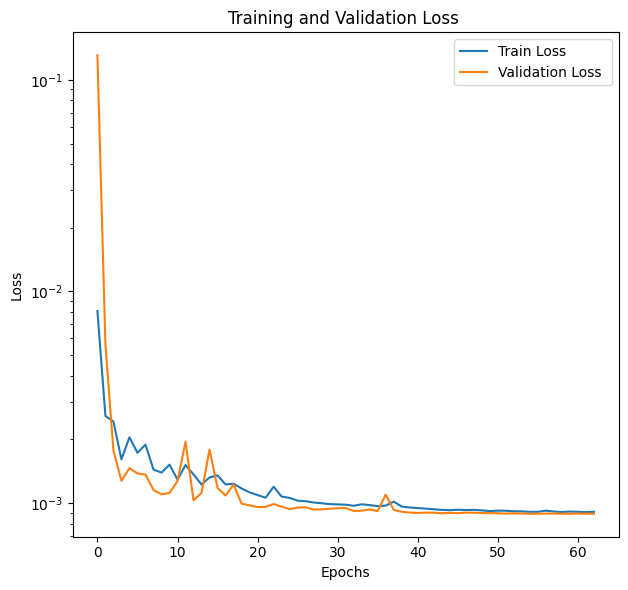

In [97]:


# Print the available keys in the history
print(history.history.keys())

# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If there are specific losses for x_prob and x_midpoints, extract them
train_loss_x_prob = history.history.get('x_prob_reshape_loss', train_loss)
val_loss_x_prob = history.history.get('val_x_prob_reshape_loss', val_loss)
train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)


# Plot the training and validation losses
plt.figure(figsize=(12, 6))

# Plotting x_prob_reshape loss
plt.subplot(1, 2,1)
plt.plot(train_loss_x_prob, label='Train Loss ')
plt.plot(val_loss_x_prob, label='Validation Loss ')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

# # Plotting x_midpoints_reshape loss
# plt.subplot(1, 2, 2)
# plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
# plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss for x_midpoints_reshape')
# plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# u =tf.keras.models.load_model("/home/da886/ElectronCountingProject/weekend steps custom loss weights/customlossmodel.keras",safe_mode=False) 

/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))

# train_dataset = train_dataset.batch(400)
# inputs,targets = next(iter(train_dataset))
# output =u.predict(inputs)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
val_dataset = val_dataset.batch(400)
inputs,targets = next(iter(val_dataset))
output =model.predict(inputs)

I0000 00:00:1724789461.022527 1098896 service.cc:146] XLA service 0x7f36c80055d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724789461.022602 1098896 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-27 20:11:01.046302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 20:11:01.276239: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step

2024-08-27 20:11:02.394990: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1724789462.508634 1098896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


In [21]:
h = np.random.randint(0,len(output))
output[h]*64,targets[h]*64

(array([[[32.00034 , 31.998962],
         [32.00136 , 32.00021 ],
         [31.998123, 31.999329]]], dtype=float32),
 <tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
 array([[[17.85842 , 25.538685],
         [24.63252 , 34.4601  ],
         [19.169195, 54.284885]]], dtype=float32)>)

In [33]:
import tensorflow as tf
def custom_loss(y_true, y_pred, exponent=9):
    diff = tf.abs(y_true - y_pred)
    powered_diff = tf.pow(diff, exponent)
    return tf.reduce_mean(powered_diff)

# # r = np.random.randint(0,100)
# tensor1 = tf.constant(targets, dtype=tf.float64)

# tensor2 = tf.constant(output, dtype=tf.float32)


# tensor2 = tf.cast(tensor2, tf.float64)


# mse_loss_fn = custom_mse(tensor1, tensor2)
# mse_loss = mse_loss_fn(tensor1, tensor2)
mse_loss_fn = custom_loss(targets, output, exponent=9)

print("MSE Loss:", mse_loss_fn.numpy())

MSE Loss: 6.345067e-06


Train dataset

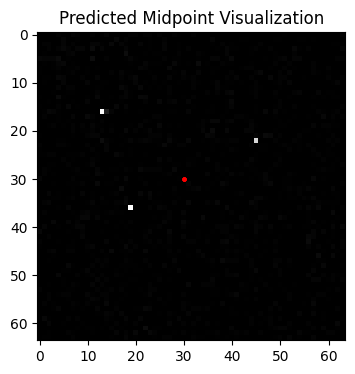

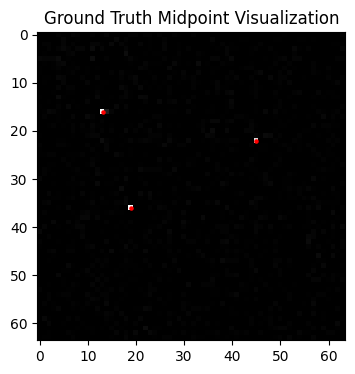

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, midpoints):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

def visualize_midpoints2(image, midpoints):
    """
    Visualizes ground truth midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

# Example usage with random data
t = np.random.randint(0, 400)   
# t=5

visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*np.max(sorted_centers))
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*np.max(sorted_centers))


Validation dataset

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
#     """
#     Visualizes midpoints on an image based on a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     prob_vector_np = probability_vector
#     midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Predicted Midpoint(Validation dataset)")

#     # Plot midpoints based on probability threshold
#     for i, (p,u) in enumerate(midpoints_np):
#         prob = prob_vector_np[i]
#         if prob > threshold:
#             plt.scatter(p, u, color='red', s=5)
#             # if i == 0:  # Add label only once to avoid repetition in the legend
#             #     plt.legend()
    
    

# t = np.random.randint(0,400)
# # t=12
# visualize_midpoints(tf.convert_to_tensor(inputs[t]), output[0][t].squeeze()*64, tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   
         
            
# def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
#     """
#     Visualizes midpoints on an image based on a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     prob_vector_np = probability_vector
#     midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Ground Truth Midpoint Visualization")

#     # Plot midpoints based on probability threshold
#     for i, (x,y) in enumerate(midpoints_np):
#         prob = prob_vector_np[i]
#         if prob > threshold:
#             plt.scatter(x, y, color='red', s=5)
#             # if i == 0:  # Add label only once to avoid repetition in the legend
#             #     plt.legend()

#     plt.show()     
# visualize_midpoints2(tf.convert_to_tensor(inputs[t]), targets['x_probabilities_reshape'][t].numpy().squeeze()*64, tf.convert_to_tensor(targets['x_midpoints_reshape'][t,0,:,:])*[64,64]) ##ground truth
# # visualize_midpoints2(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64])          




In [151]:
model.save("/home/da886/Electron Counting Extended Arch/Weights/Mixed_sortedcentersasnormmax.keras")

In [29]:
# import tensorflow as tf
# import numpy as np

# # # Assuming train_images and train_midpoints are already defined
# # train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# # train_dataset = train_dataset.batch(200)
# # inputs, targets = next(iter(train_dataset))

# # # Predict the midpoints
# # output = model.predict(inputs)

# # Define the distance function
# def calculate_distance(pred_midpoint, true_midpoint):
#     return tf.sqrt(tf.reduce_sum(tf.square(pred_midpoint - true_midpoint), axis=-1))

# # Set the distance threshold
# distance_threshold = 0.2  # Adjust based on your specific data and scale

# # Initialize counters
# true_positives = 0
# false_positives = 0
# false_negatives = 0

# # Calculate distances and determine true positives, false positives, false negatives
# for pred_midpoint, true_midpoint in zip(output, targets):
#     distance = calculate_distance(pred_midpoint, true_midpoint)
#     distance = tf.reduce_mean(distance)  # Ensure `distance` is a scalar

#     if distance <= distance_threshold:
#         true_positives += 1
#     else:
#         false_positives += 1

# # Calculate false negatives
# false_negatives = len(targets) - true_positives

# # Calculate precision
# precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())

# # Calculate recall
# recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

# # Calculate F1 score
# f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

# # Output the results
# print(f'Precision: {precision}')
# print(f'F1 Score: {f1_score}')


In [1]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error

# Assume you have a batch of inputs and targets
inputs, targets = next(iter(train_dataset))

# Get model predictions for this batch
output = model.predict(inputs)

# Calculate MSE for each prediction in the batch
mse_values = mean_squared_error(targets, output, multioutput='raw_values')

# Find the minimum and maximum MSE in the batch
min_mse = mse_values.min()
max_mse = mse_values.max()

print("Minimum MSE for this batch:", min_mse)
print("Maximum MSE for this batch:", max_mse)


2024-08-27 20:06:32.129485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 20:06:32.144038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 20:06:32.157490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 20:06:32.161598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 20:06:32.173919: I tensorflow/core/platform/cpu_feature_guar

NameError: name 'train_dataset' is not defined

In [ ]:
# Repeat the same process for validation dataset
min_mse_all_val = np.inf
max_mse_all_val = -np.inf

for inputs, targets in val_dataset:
    output = model.predict(inputs)
    
    mse_values = mean_squared_error(targets, output, multioutput='raw_values')
    
    min_mse_batch = mse_values.min()
    max_mse_batch = mse_values.max()
    
    if min_mse_batch < min_mse_all_val:
        min_mse_all_val = min_mse_batch
    
    if max_mse_batch > max_mse_all_val:
        max_mse_all_val = max_mse_batch

print("Minimum MSE across all validation batches:", min_mse_all_val)
print("Maximum MSE across all validation batches:", max_mse_all_val)
